In [1]:
!pip install -q torch torchvision matplotlib scikit-learn seaborn numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader, random_split

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

In [5]:
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

100%|██████████| 170M/170M [00:03<00:00, 43.6MB/s]


In [6]:
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

print(f"Training set size: {len(trainset)}")
print(f"Validation set size: {len(valset)}")

Training set size: 40000
Validation set size: 10000


In [7]:
batch_size = 128 
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

In [8]:
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
print(f"Test set size: {len(testset)}")

Test set size: 10000


In [9]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride = 1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion * planes:
      self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

  def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = self.bn2(self.conv2(out))
      out += self.shortcut(x)
      out = F.relu(out)
      return out

In [11]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks_list, num_classes=10, in_channels_initial=3):
        super(ResNet, self).__init__()
        self.in_planes = 64


        self.conv1 = nn.Conv2d(in_channels_initial, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)


        self.layer1 = self._make_layer(block, 64, num_blocks_list[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks_list[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks_list[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks_list[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

def ResNet34(num_classes=10, in_channels_initial=3):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, in_channels_initial=in_channels_initial)


In [12]:
def train_validate_model(model, model_name, train_loader, val_loader, device, num_epochs=10, learning_rate=0.001, weight_decay_val=0.0, aux_loss_weight=0.4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_val)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print(f"\nBắt đầu huấn luyện cho {model_name} trên thiết bị {device}...")

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            if isinstance(outputs, tuple):
                outputs_main, outputs_aux = outputs
                loss_main = criterion(outputs_main, labels)
                loss_aux = criterion(outputs_aux, labels)
                loss = loss_main + aux_loss_weight * loss_aux
                _, predicted = torch.max(outputs_main.data, 1)
            else:
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if (i + 1) % (len(train_loader) // 2) == 0 and i > 0 and len(train_loader) > 1 :
                print(f'{model_name} - Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss Batch Hiện Tại: {loss.item():.4f}')

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs_val, labels_val in val_loader:
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                outputs_val = model(inputs_val)

                if isinstance(outputs_val, tuple):
                    outputs_main_val, _ = outputs_val
                    loss_v = criterion(outputs_main_val, labels_val)
                    _, predicted_val = torch.max(outputs_main_val.data, 1)
                else:
                    loss_v = criterion(outputs_val, labels_val)
                    _, predicted_val = torch.max(outputs_val.data, 1)

                running_val_loss += loss_v.item() * inputs_val.size(0)
                total_val += labels_val.size(0)
                correct_val += (predicted_val == labels_val).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"{model_name} - Epoch [{epoch + 1}/{num_epochs}]: "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    print(f"Hoàn thành huấn luyện cho {model_name}.")
    return history


def plot_history(history, model_name):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [13]:
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
WEIGHT_DECAY = 1e-4
NUM_CLASSES_CIFAR10 = 10


In [14]:
model_resnet34_scratch = ResNet34(num_classes=NUM_CLASSES_CIFAR10).to(device)

history_resnet34 = train_validate_model(
        model=model_resnet34_scratch,
        model_name="ResNet34_FromScratch_CIFAR10",
        train_loader=trainloader,
        val_loader=valloader,
        device=device,
        num_epochs=NUM_EPOCHS,
        learning_rate=LEARNING_RATE,
        weight_decay_val=WEIGHT_DECAY
    )


Bắt đầu huấn luyện cho ResNet34_FromScratch_CIFAR10 trên thiết bị cuda...
ResNet34_FromScratch_CIFAR10 - Epoch [1/30], Step [156/313], Loss Batch Hiện Tại: 1.5752
ResNet34_FromScratch_CIFAR10 - Epoch [1/30], Step [312/313], Loss Batch Hiện Tại: 1.6489
ResNet34_FromScratch_CIFAR10 - Epoch [1/30]: Train Loss: 1.7543, Train Acc: 0.3498 | Val Loss: 1.5299, Val Acc: 0.4415
ResNet34_FromScratch_CIFAR10 - Epoch [2/30], Step [156/313], Loss Batch Hiện Tại: 1.2891
ResNet34_FromScratch_CIFAR10 - Epoch [2/30], Step [312/313], Loss Batch Hiện Tại: 1.0723
ResNet34_FromScratch_CIFAR10 - Epoch [2/30]: Train Loss: 1.3021, Train Acc: 0.5232 | Val Loss: 1.2424, Val Acc: 0.5594
ResNet34_FromScratch_CIFAR10 - Epoch [3/30], Step [156/313], Loss Batch Hiện Tại: 1.1651
ResNet34_FromScratch_CIFAR10 - Epoch [3/30], Step [312/313], Loss Batch Hiện Tại: 0.7677
ResNet34_FromScratch_CIFAR10 - Epoch [3/30]: Train Loss: 1.0486, Train Acc: 0.6280 | Val Loss: 1.0331, Val Acc: 0.6376
ResNet34_FromScratch_CIFAR10 - Epo

<ipython-input-12-efc1c28c7d8d>:100: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


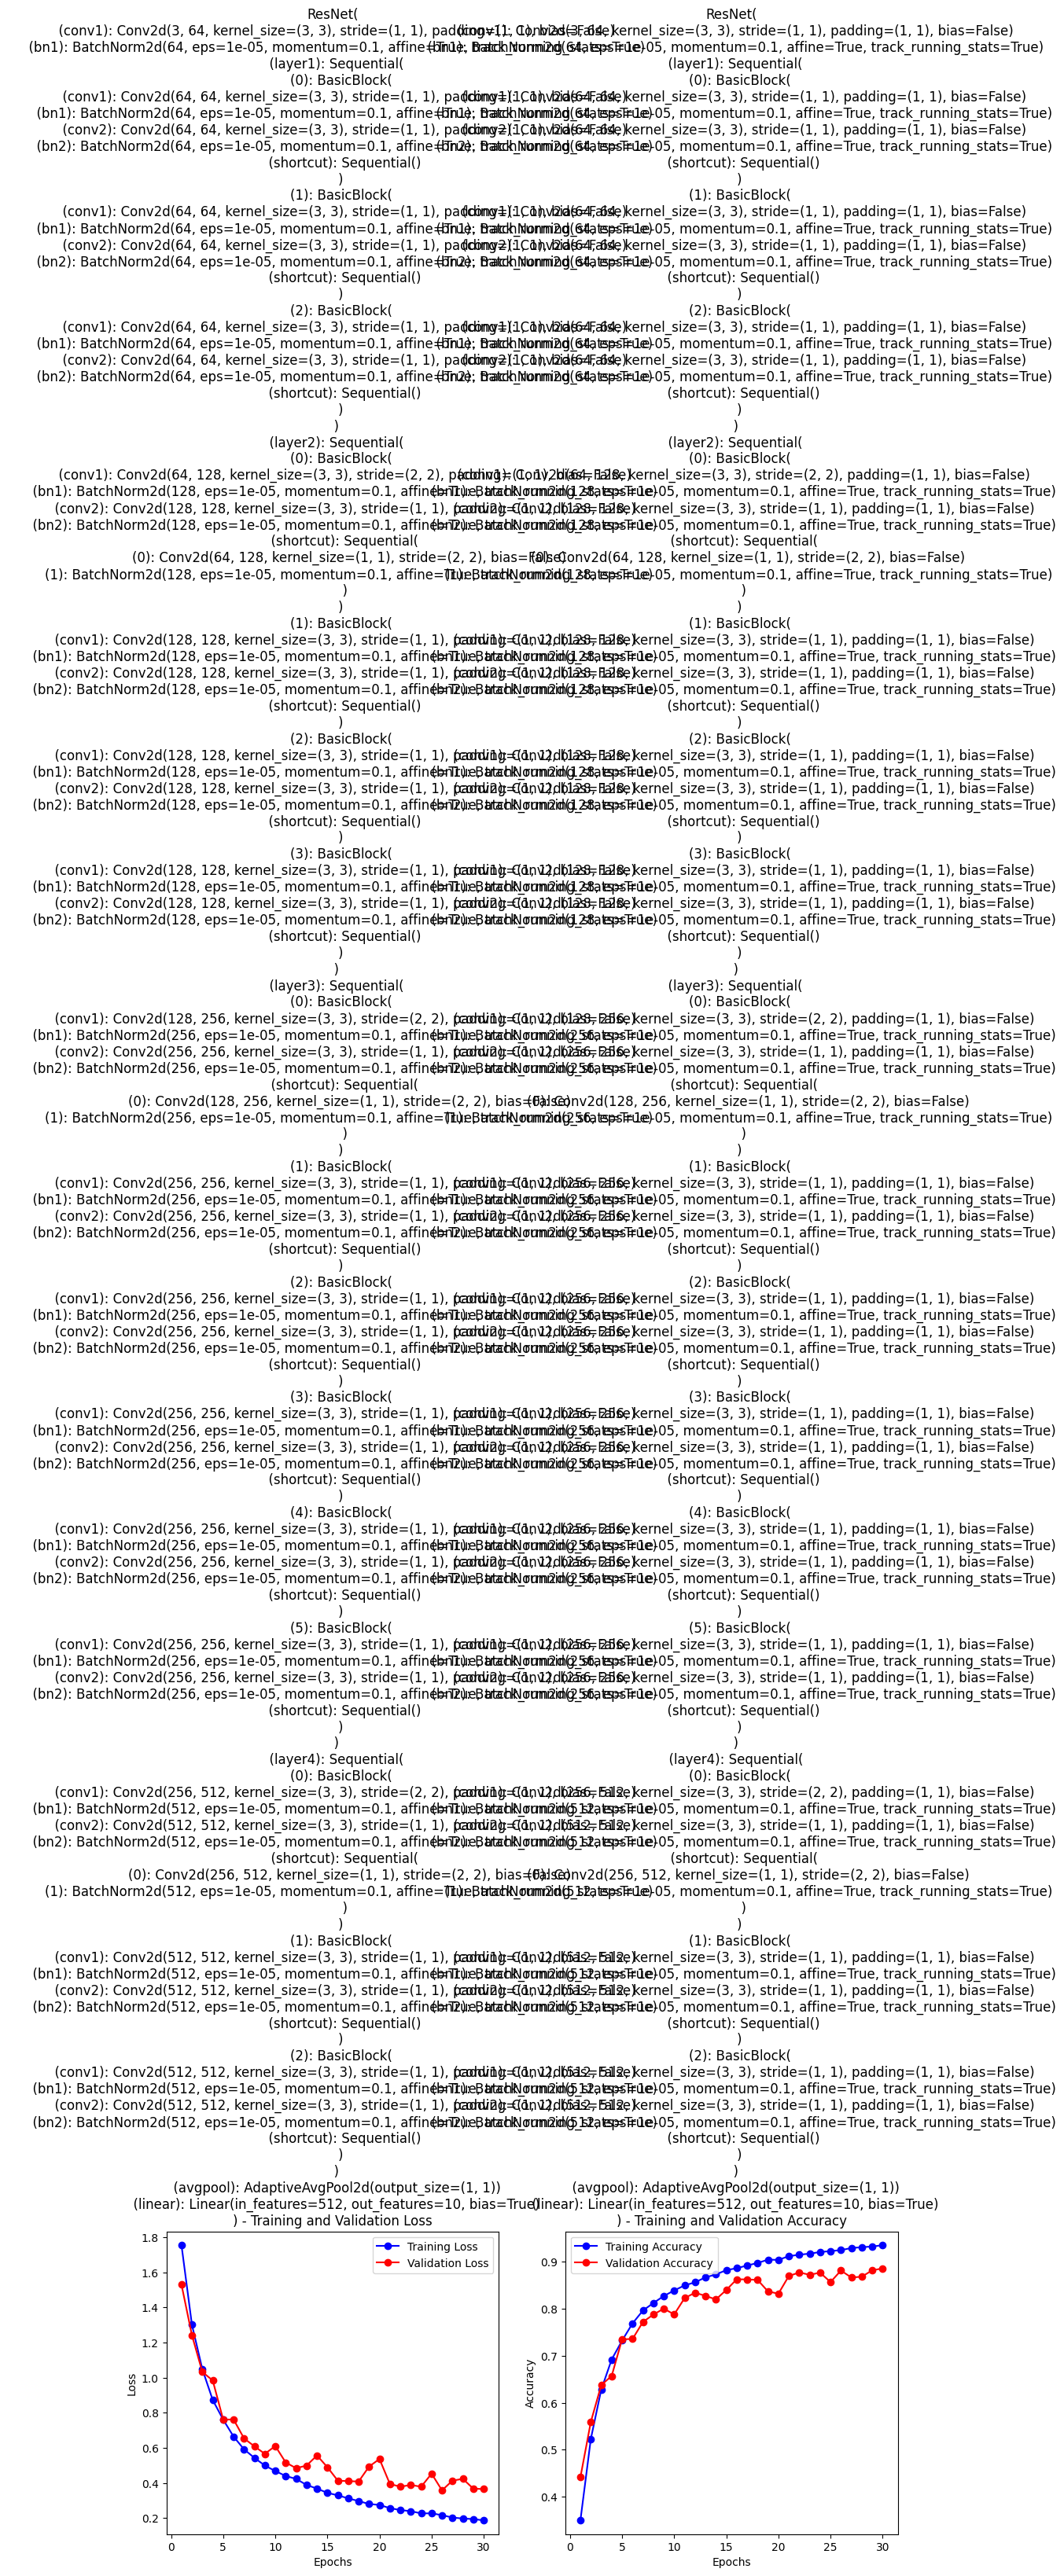

In [15]:
plot_history(history_resnet34, model_resnet34_scratch)

In [16]:
def test_model(model, test_loader, device, criterion=None):
    model.eval()
    all_preds = []
    all_labels = []
    correct_test = 0
    total_test = 0
    running_test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)


            if isinstance(outputs, tuple):
                outputs_main = outputs[0]
            else:
                outputs_main = outputs


            if criterion:
                loss = criterion(outputs_main, labels)
                running_test_loss += loss.item() * inputs.size(0)


            _, predicted = torch.max(outputs_main.data, 1)

            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = correct_test / total_test
    print(f"Test Accuracy: {test_acc:.4f}")

    if criterion:
        avg_test_loss = running_test_loss / len(test_loader.dataset)
        print(f"Average Test Loss: {avg_test_loss:.4f}")
        return test_acc, avg_test_loss, all_labels, all_preds
    else:
        return test_acc, all_labels, all_preds


In [17]:
model_resnet3_acc_test, model_resnet34_labels, model_resnet34_preds = test_model(model_resnet34_scratch, testloader, device)

Test Accuracy: 0.8877


In [18]:

def plot_confusion_matrix_func(all_labels, all_preds, class_names, model_name):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}'); plt.show()


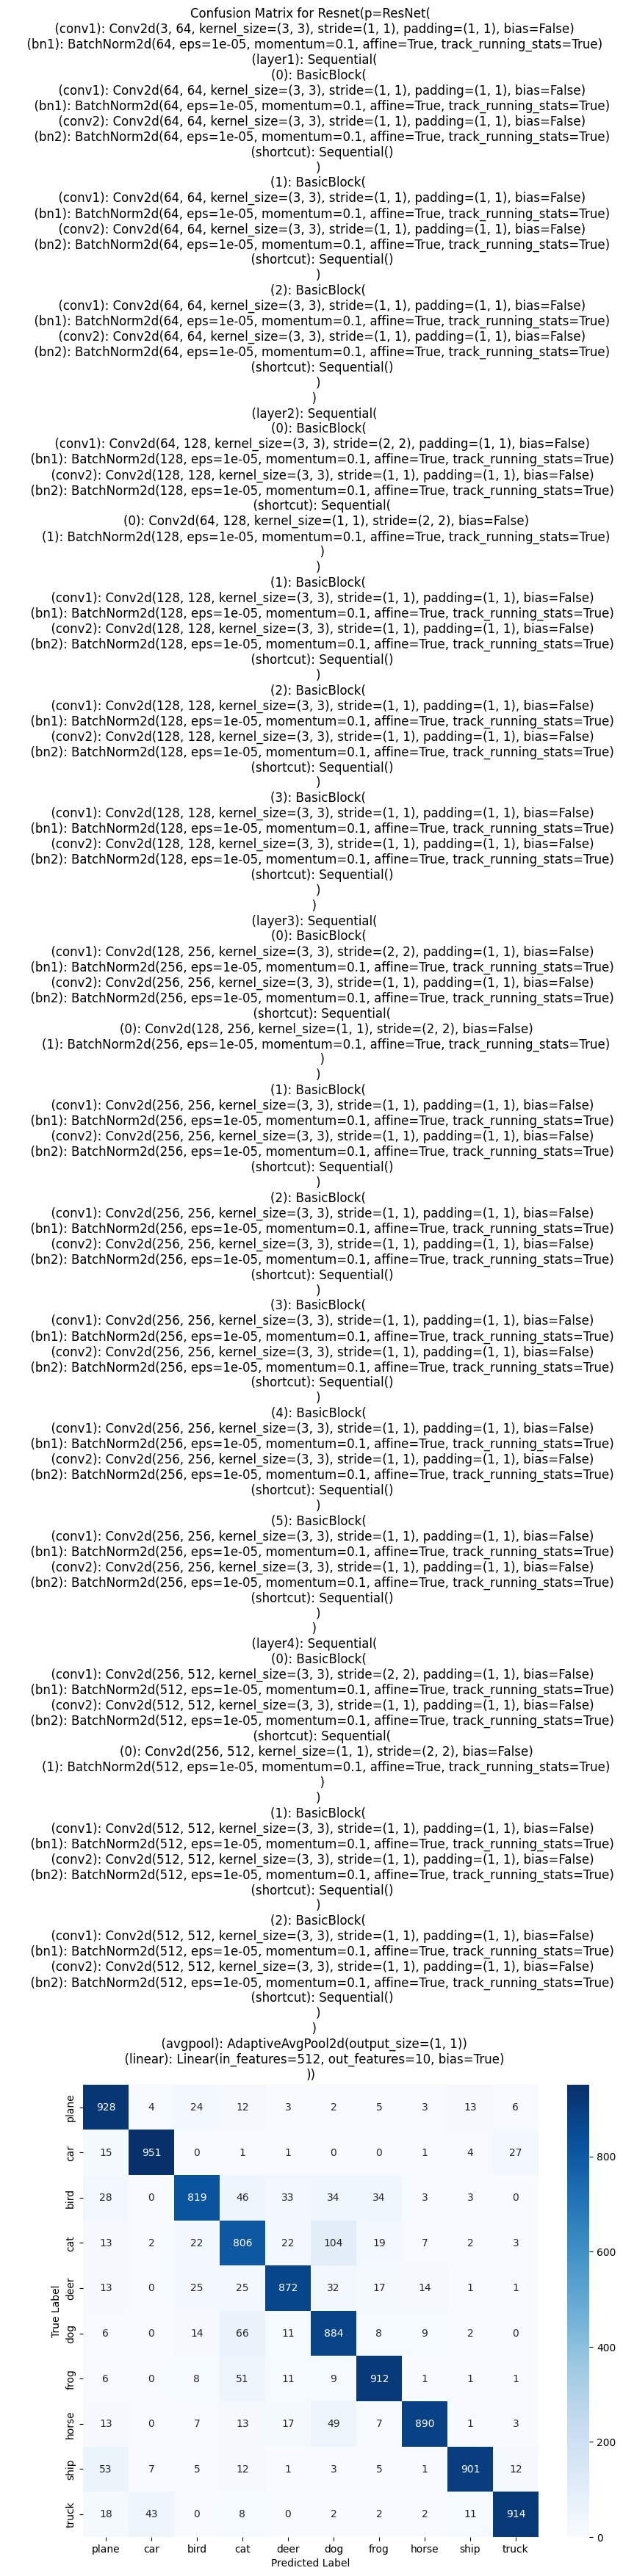

In [21]:
plot_confusion_matrix_func(model_resnet34_labels, model_resnet34_preds, classes, f"Resnet(p={model_resnet34_scratch})")

In [20]:
torch.save(model_resnet34_scratch, "resNET_model.pth")